In [1]:
# Install necessary libraries
%pip install torchvision split-folders -q

# Imports
import os, shutil, gc, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v2

from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm
from termcolor import colored
from warnings import filterwarnings

sns.set_style('darkgrid')
filterwarnings('ignore')

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configs
img_size = (128, 128)
batch_size = 64
num_epochs = 50  # early stopping will be used


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.6 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.
Using device: cuda


In [2]:
import splitfolders

# Directories
base_dir = '/kaggle/input/bloodc/Original'
working_dir = '/kaggle/working/'
Images = os.path.join(working_dir, 'Images')

# Create structure and copy images
os.makedirs(Images, exist_ok=True)
for class_name in os.listdir(base_dir):
    class_path = os.path.join(Images, class_name)
    os.makedirs(class_path, exist_ok=True)
    for img in os.listdir(os.path.join(base_dir, class_name)):
        shutil.copy(os.path.join(base_dir, class_name, img), class_path)

print(colored('Images copied', 'green'))

# Dataset Split
splitfolders.ratio(input=Images, output=os.path.join(working_dir, 'train_valid'), seed=42, ratio=(0.7, 0.15, 0.15))


Images copied


Copying files: 3256 files [00:00, 7549.16 files/s]


In [3]:
# Augmentations
transform_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

transform_val_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])

# Dataset and Dataloaders
train_dir = os.path.join(working_dir, 'train_valid/train')
val_dir = os.path.join(working_dir, 'train_valid/val')
test_dir = os.path.join(working_dir, 'train_valid/test')

train_ds = ImageFolder(root=train_dir, transform=transform_train)
valid_ds = ImageFolder(root=val_dir, transform=transform_val_test)
test_ds = ImageFolder(root=test_dir, transform=transform_val_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

classes = train_ds.classes
num_classes = len(classes)
print(f"Classes: {classes}")


Classes: ['Benign', 'Early', 'Pre', 'Pro']


In [4]:
model = mobilenet_v2(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.last_channel, num_classes)
)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 182MB/s]


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

best_val_loss = float('inf')
patience = 7
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = train_correct / len(train_ds)
    val_loss, val_correct = 0, 0

    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_correct / len(valid_ds)
    print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.4036, Val Acc: 0.4362


Epoch 2/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.5977, Val Acc: 0.7058


Epoch 3/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.6961, Val Acc: 0.7202


Epoch 4/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.7541, Val Acc: 0.7613


Epoch 5/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.7782, Val Acc: 0.8128


Epoch 6/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.8050, Val Acc: 0.8189


Epoch 7/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.8362, Val Acc: 0.8272


Epoch 8/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.8502, Val Acc: 0.8272


Epoch 9/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.8590, Val Acc: 0.8580


Epoch 10/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.8595, Val Acc: 0.8745


Epoch 11/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.8735, Val Acc: 0.8807


Epoch 12/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.8775, Val Acc: 0.8848


Epoch 13/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.8836, Val Acc: 0.8827


Epoch 14/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.8893, Val Acc: 0.8889


Epoch 15/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.8911, Val Acc: 0.8951


Epoch 16/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.8819, Val Acc: 0.9033


Epoch 17/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.8889, Val Acc: 0.8971


Epoch 18/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.8924, Val Acc: 0.9053


Epoch 19/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.8924, Val Acc: 0.8930


Epoch 20/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9135, Val Acc: 0.9074


Epoch 21/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9065, Val Acc: 0.9115


Epoch 22/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.8928, Val Acc: 0.9074


Epoch 23/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9095, Val Acc: 0.9053


Epoch 24/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9065, Val Acc: 0.9053


Epoch 25/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9003, Val Acc: 0.9115


Epoch 26/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9152, Val Acc: 0.9136


Epoch 27/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9038, Val Acc: 0.9156


Epoch 28/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9051, Val Acc: 0.9218


Epoch 29/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9161, Val Acc: 0.9095


Epoch 30/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9034, Val Acc: 0.9095


Epoch 31/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9117, Val Acc: 0.9156


Epoch 32/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9236, Val Acc: 0.9259


Epoch 33/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9218, Val Acc: 0.9115


Epoch 34/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9183, Val Acc: 0.9239


Epoch 35/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9095, Val Acc: 0.9136


Epoch 36/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9152, Val Acc: 0.9198


Epoch 37/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9166, Val Acc: 0.9198


Epoch 38/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9148, Val Acc: 0.9198


Epoch 39/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9188, Val Acc: 0.9156


Epoch 40/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9100, Val Acc: 0.9239


Epoch 41/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9179, Val Acc: 0.9177


Epoch 42/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9117, Val Acc: 0.9218


Epoch 43/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9144, Val Acc: 0.9239


Epoch 44/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9139, Val Acc: 0.9198


Epoch 45/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9126, Val Acc: 0.9156


Epoch 46/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9183, Val Acc: 0.9218


Epoch 47/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9297, Val Acc: 0.9218


Epoch 48/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9183, Val Acc: 0.9156


Epoch 49/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9262, Val Acc: 0.9239


Epoch 50/50:   0%|          | 0/36 [00:00<?, ?it/s]

Train Acc: 0.9236, Val Acc: 0.9198


Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      0.90      0.92        77
       Early       0.89      0.95      0.92       149
         Pre       0.96      0.93      0.94       145
         Pro       0.99      0.98      0.98       122

    accuracy                           0.94       493
   macro avg       0.95      0.94      0.94       493
weighted avg       0.94      0.94      0.94       493



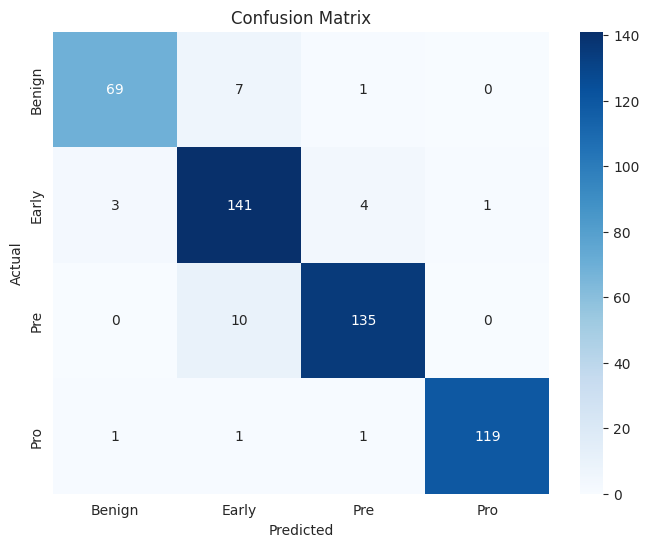

In [6]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

# Metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
